# Annotation Bounding Boxes

This example shows how to use the camera sensor to get both semantic and instance annotations from the simulation and extract bounding box information from those two channels. The identified bounding boxes will then be drawn onto the regular color image of the camera and encoded as XML.

## Scenario

For our demonstration, we'll set up an intersection with a total of five cars on it, two facing the ego vehicle, and two going in the same direction as the ego vehicle. The cars will be placed such that they partially overlap each other, meaning they become inseparable in the semantic annotation as their class colors are the same, illustrating the use of instance annotations.

## Setup

The classes required in this example boil down to the following:

* `BeamNGpy`: The main class representing the simulator, used to control the simulation process from Python.
* `Scenario` : Used to specify the desired scenario, i.e. the level we want to use and which vehicles are participating.
* `Vehicle`: Class representing a vehicle. Our scenario will contain five `Vehicle` instances with different models, one being the ego vehicle we will get the perspective of and four being other cars crossing the intersection.
* `Camera`: The camera sensor used to get image data and annotation information from the simulator. In addition to the sensor simulation it also contains utility functions to process that data further, such as bounding box analysis and encoding.

In [1]:
%matplotlib inline

import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from beamngpy import BeamNGpy, Vehicle, Scenario
from beamngpy.sensors import Camera

For scenario creation we will instantiate the `Scenario` class with the desired map and scenario name as the respective parameters. Five instances of the `Vehicle` class are then created and added to the scenario at their respective positions. These positions were determined by manually loading the map and finding desired locations using the World Editor.

In [2]:
beamng = BeamNGpy('localhost', 64256)

scenario = Scenario('west_coast_usa', 'annotation_bounding_boxes')

ego = Vehicle('ego', model='etk800', color='White')
scenario.add_vehicle(ego, pos=(-725.365, 92.4684, 118.437),
                     rot_quat=(-0.006, -0.0076, 0.921, -0.389))

camera = Camera((-0.3, 1, 1), (0, 1, 0), 75, (1024, 1024), colour=True,
                depth=True, annotation=True, instance=True)
ego.attach_sensor('camera', camera)

car1 = Vehicle('car1', model='etk800', color='Green')
scenario.add_vehicle(car1, pos=(-710.76, 101.50, 118.56),
                     rot_quat=(-0.006, -0.0076, 0.921, -0.389))

car2 = Vehicle('car2', model='etk800', color='Red')
scenario.add_vehicle(car2, pos=(-715.83, 96.69, 118.53),
                     rot_quat=(-0.006, -0.0076, 0.921, -0.389))

car3 = Vehicle('car3', model='etki', color='Blue')
scenario.add_vehicle(car3, pos=(-696.96, 126.9, 118.44),
                     rot_quat=(0.0181, -0.0065, 0.3816, 0.924))

car4 = Vehicle('car4', model='miramar', color='Black')
scenario.add_vehicle(car4, pos=(-708.58203, 115.326, 118.60),
                     rot_quat=(0.0181, -0.00645, 0.3818, 0.9240))

scenario.make(beamng)

The first vehicle added, as the name implies, is our ego-vehicle. It is also equipped with a camera sensor that is configured to return semantic and instance annotation, indicated by the `annotation` and `instance` flags. This means the captured data will contain at least three images: the regular color image rendered, an additional image where each pixel is colored according to the class of the object the pixel belongs to, and another image where each pixel's color is a unique color of the object it belongs to, i.e. even though multiple cars have the same class and thus the same color in the semantic annotations, they have a different color in the instance annotations.

Finally, the scenario is compiled and placed in a location where the simulator can find it by calling `scenario.make(beamng)` at the end. This means we can start the simulation and load our scenario.

## Running

We first start the simulator and then immediately tell it to load our scenario. Once it is loaded, we move on to capturing data from the camera sensor. This is used by calling `poll_sensors` on our ego-vehicle, which has a camera attached according to our scenario definition. For later processing we also retrieve the annotation color configuration of the simulator using the `bng.get_annotations()` function. This will be used later to identify what class of object a color refers to. After that, we can close the simulator as all further processing is done offline.

In [3]:
bng = beamng.open()
bng.load_scenario(scenario)
bng.start_scenario()
time.sleep(20)  # Some sleeping time to make sure the level fully loaded.

ego.poll_sensors()
data = ego.sensors['camera'].data
annotations = bng.get_annotations()

bng.close()

## Analysis

The camera sensor provided us with three captured images: regular color information, semantic annotation, and instance annotation. Each of these images can be seen below:

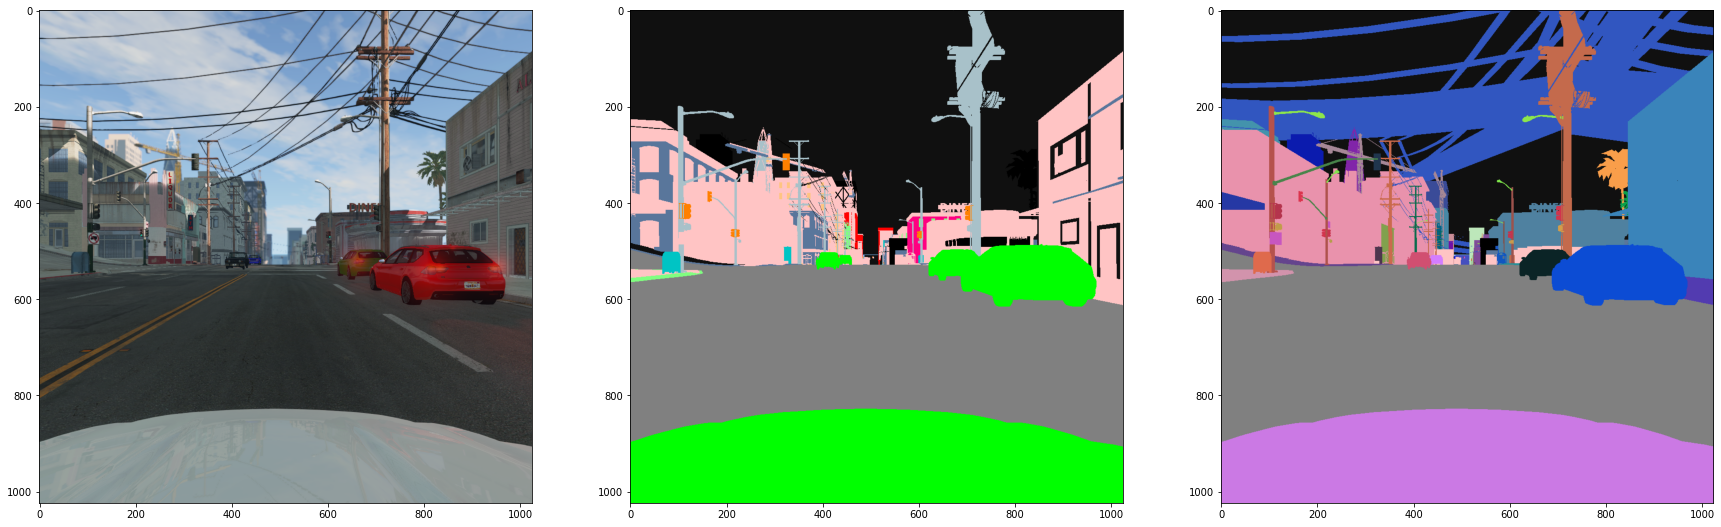

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(np.asarray(data['colour'].convert('RGB')))
ax[1].imshow(np.asarray(data['annotation'].convert('RGB')))
ax[2].imshow(np.asarray(data['instance'].convert('RGB')))

With both semantic and instance annoations, we can use a utility function of the `Camera` sensor to extract bounding boxes of objects in the image. This is done with the `Camera.extract_bboxes` function. To map colors to object classes this function requires a respective dictionary. Since we obtained the annotation configuration earlier, we can generate such a dictionary using the `beamng.get_annotation_classes()` function. We then use that and the previously obtained images to extract bounding boxes of the image. This example will focus on vehicles seen by the camera, so we will narrow down the list to only bounding boxes of vehicles.

In [5]:
classes = beamng.get_annotation_classes(annotations)
bboxes = Camera.extract_bboxes(data['annotation'], data['instance'], classes)
bboxes = [b for b in bboxes if b['class'] == 'CAR']
bboxes

[{'bbox': [687, 486, 968, 613], 'class': 'CAR', 'color': [12, 76, 212, 255]},
 {'bbox': [620, 497, 724, 560], 'class': 'CAR', 'color': [11, 36, 38, 255]},
 {'bbox': [386, 503, 436, 538], 'class': 'CAR', 'color': [209, 79, 113, 255]},
 {'bbox': [433, 509, 460, 528], 'class': 'CAR', 'color': [212, 125, 255, 255]},
 {'bbox': [0, 828, 1023, 1023], 'class': 'CAR', 'color': [203, 121, 228, 255]}]

The resulting list contains exactly five vehicles. Each entry in this list has the bounding box corners in pixel coordinates, the class of the object, and the color of the object in the instance annotations. This can now be used to draw bounding boxes onto our regular color image with the `Camera.draw_bboxes()` function.

<Figure size 432x288 with 0 Axes>

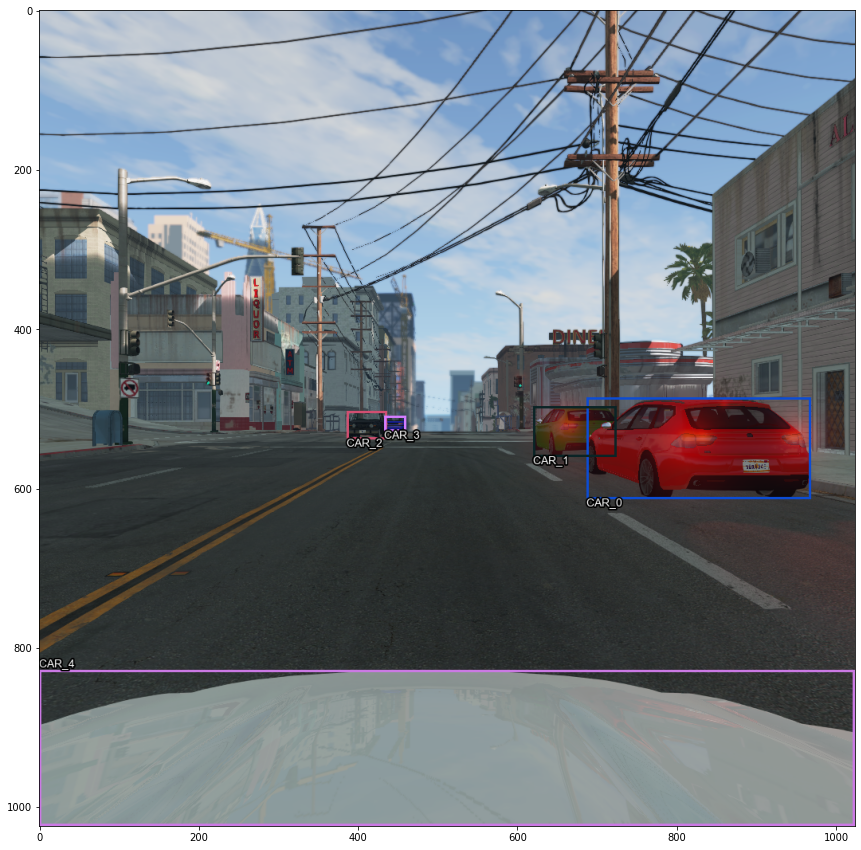

In [12]:
bbox_img = Camera.draw_bboxes(bboxes, data['colour'], width=3)
plt.clf()
plt.figure(figsize=(15, 15))
plt.imshow(np.asarray(bbox_img.convert('RGB')))

The same information can also be encoded as Pascal-VOC XML with the `Camera.export_bbox_xml()` function:

In [14]:
xml = Camera.export_bbox_xml(bboxes, filename='example.png', size=(1024, 1024, 3))
print(xml)

<?xml version="1.0" ?>
<annotation>
  <filename>example.png</filename>
  <size>
    <width>1024</width>
    <height>1024</height>
    <depth>3</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>CAR_0</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>687</xmin>
      <ymin>486</ymin>
      <xmax>968</xmax>
      <ymax>613</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_1</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>620</xmin>
      <ymin>497</ymin>
      <xmax>724</xmax>
      <ymax>560</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_2</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>386</xmin>
      <ymin>503</ymin>
      <xmax>436</xmax>
      <ymax>538</ymax>
    </bndbox>
  </object>
  <object>
    <name>CAR_3</name>
    <pose>Unspecified<